#Natural Language Classifier


Import and save movie plot, title and genre to a numpy array. Discarding movie data with genre marked as 'unknown' other data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Q1 Dataset


In [ ]:
import numpy as np
import re


# load CSV file as a list of lines
#!wget -0

with open('drive/MyDrive/wiki_movie_plots_deduped.csv', 'r') as f:
    lines = f.readlines()

# remove header line
lines = lines[2:]

# use regular expression to split each line into columns
data = []
for line in lines:
    line = line.strip()
    columns = re.split(r',(?=(?:[^"]*"[^"]*")*[^"]*$)', line)
    if len(columns) == 8:
        data.append(columns)
# filter out entries with unknown genre
data = [line for line in data if line[5] != 'unknown']

# extract Title, Plot, and Genre columns
title = [line[1] for line in data]
plot = [line[7] for line in data]
genre = [line[5] for line in data]

#combine entries into single numpy array
movie_plots = np.column_stack((title, plot, genre))

print(movie_plots.shape)

(17349, 3)


Random sample the corpus to reduce to 10000 entries then split into 60/20/20

Random sampling the data to reduce the corpus size to 10000 entries and checking the labels

In [ ]:

random_indices = np.random.choice(movie_plots.shape[0], 10000, replace=False)
random_sample = movie_plots[random_indices]

unique_genres, counts = np.unique(random_sample[:,2], return_counts=True)

sorted_indices = np.argsort(counts)[::-1]

top_genres = unique_genres[sorted_indices][:10]
mask = np.isin(random_sample[:,2], top_genres)
top_movies = random_sample[mask]


# for i in range(min(10, len(sorted_indices))):
#     print(f"{unique_genres[sorted_indices[i]]}: {counts[sorted_indices[i]]}")

# print(top_movies.shape, top_movies)

A lot of the genres a multilabel and have a a count of one, im going to only keep the top 10 single label genres to clean up my dataset to ensure a more accurate model.


In [ ]:
unique_genres, counts = np.unique(random_sample[:,2], return_counts=True)

sorted_indices = np.argsort(counts)[::-1]

top_genres = unique_genres[sorted_indices][:10]
mask = np.isin(random_sample[:,2], top_genres)
clean_data = random_sample[mask]


# for i in range(min(10, len(sorted_indices))):
#     print(f"{unique_genres[sorted_indices[i]]}: {counts[sorted_indices[i]]}")

# print(top_movies.shape, top_genres)

Split corpus into 60/20/20 for training/validation/testing

In [ ]:
train_data, validation_data, test_data = np.split(clean_data, [int(0.6 * len(clean_data)), int(0.8 * len(clean_data))])

In [ ]:
print("Train data shape:", train_data.shape)
print("Validation data shape:", validation_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1867, 3)
Validation data shape: (622, 3)
Test data shape: (623, 3)


In [ ]:
train_genre_counts = np.unique(train_data[:,2], return_counts=True)[1]
val_genre_counts = np.unique(validation_data[:,2], return_counts=True)[1]
test_genre_counts = np.unique(test_data[:,2], return_counts=True)[1]

# calculate the percentage of each genre in each of the three arrays
train_genre_pct = train_genre_counts / len(train_data) * 100
val_genre_pct = val_genre_counts / len(validation_data) * 100
test_genre_pct = test_genre_counts / len(test_data) * 100

genres = np.unique(clean_data[:, 2])

# print the genre percentages for each of the three arrays
print("Genre percentages in training set:")
for i in range(len(genres)):
    print("{}: {:.2f}%".format(genres[i], train_genre_pct[i]))

print("Genre percentages in validation set:")
for i in range(len(genres)):
    print("{}: {:.2f}%".format(genres[i], val_genre_pct[i]))

print("Genre percentages in test set:")
for i in range(len(genres)):
    print("{}: {:.2f}%".format(genres[i], test_genre_pct[i]))

Genre percentages in training set:
action: 6.43%
adventure: 3.32%
comedy: 24.21%
crime: 3.70%
drama: 39.15%
horror: 3.80%
musical: 3.11%
romance: 6.80%
thriller: 4.77%
western: 4.71%
Genre percentages in validation set:
action: 6.27%
adventure: 2.73%
comedy: 24.12%
crime: 4.50%
drama: 36.17%
horror: 3.38%
musical: 3.54%
romance: 9.32%
thriller: 6.11%
western: 3.86%
Genre percentages in test set:
action: 6.90%
adventure: 1.93%
comedy: 23.92%
crime: 5.78%
drama: 34.67%
horror: 5.46%
musical: 3.69%
romance: 6.74%
thriller: 3.85%
western: 7.06%


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer

Define Tokenizer

In [ ]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

# Q2 Clustering


Step 0 - Vectorise Text and Normalise

In [ ]:

vectorizer = TfidfVectorizer(tokenizer=text_pipeline_spacy)
vector_matrix = vectorizer.fit_transform(train_data[:,1])


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Step 1: Pick k random "centroids"

In [ ]:
import random
from scipy.sparse import csr_matrix

def pick_random_centroids(text_vector,k):
  random_centroid_indices = np.random.choice(text_vector.shape[0], k, replace=False)
  random_centroids = csr_matrix(text_vector[random_centroid_indices])

  return random_centroids

Step 2 - Assign each vector to its closest centroid

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def assign_vectors(centroids,plot_vectors):
  assignments = {}

  for vector_index, vector in enumerate(plot_vectors):
    closest_centroid = None
    similarity_scores = []
    for centroid_index, centroid in enumerate(centroids):
      similarity = cosine_similarity(vector.toarray()[0].reshape(1,-1),centroid.toarray()[0].reshape(1,-1))
      similarity_scores.append(similarity[0,0])
    assignments[vector_index] = np.argmax(similarity_scores)
  return assignments


Step 3 -  Recalculate the centroids based on the closest vectors

In [ ]:
from scipy.sparse import csr_matrix, vstack

def recalculate_centroids(num_centroids, centroids, plot_vectors, assignments):
  new_centroids = []
  for i in range(num_centroids):
    group = []
    for vector_index, centroid_index in assignments.items():
      if centroid_index == i:
        group.append(plot_vectors[vector_index])
    stacked_arrays = vstack(group)
    new_centroids.append(csr_matrix(np.mean(stacked_arrays, axis = 0)))
    #print(type(new_centroids))

  return new_centroids


Step 4 - Repeat steps 2 and 3 intil model converges

In [ ]:
from collections import Counter

def recalculate_centroids_until_converge(k,plot_vectors):
  centroids = pick_random_centroids(plot_vectors, k)
  assignments = assign_vectors(centroids,plot_vectors)
  centroid_vector_counter = Counter(assignments.values())
  new_centroid_vector_counter = 0
  num_centroids = k
  

  converged = False

  iterations = 0


  while not (converged):
    iterations += 1
    #print(iterations)

    new_centroids = recalculate_centroids(num_centroids, centroids, plot_vectors, assignments)
    assignments = assign_vectors(new_centroids,plot_vectors)
    new_centroid_vector_counter = Counter(assignments.values())

    #print(new_centroids)

    converged = (centroid_vector_counter == new_centroid_vector_counter)

    centroid_vector_counter = new_centroid_vector_counter
    centroids = new_centroids

  return assignments, centroids, iterations


assignments, converged_centroids, num_iterations = recalculate_centroids_until_converge(5,vector_matrix)






Q2(a) - Examples of the documents assigned to each cluster.

In [ ]:
print("Cluster 0")
indices_at_cluster_0 = [k for k, v in assignments.items() if v == 0]
example_indices_0 = random.sample(range(len(indices_at_cluster_0)), 3)
for i in example_indices_0: print(train_data[i,1]+"\n")
print(Counter([train_data[i,2] for i in indices_at_cluster_0]))
print()

print("Cluster 1")
indices_at_cluster_1 = [k for k, v in assignments.items() if v == 1]
example_indices_1 = random.sample(range(len(indices_at_cluster_1)), 3)
for i in example_indices_1: print(train_data[i,1]+"\n")
print(Counter([train_data[i,2] for i in indices_at_cluster_1]))
print()

print("Cluster 2")
indices_at_cluster_2 = [k for k, v in assignments.items() if v == 2]
example_indices_2 = random.sample(range(len(indices_at_cluster_2)), 3)
for i in example_indices_2: print(train_data[i,1]+"\n")
print(Counter([train_data[i,2] for i in indices_at_cluster_2]))
print()

print("Cluster 3")
indices_at_cluster_3 = [k for k, v in assignments.items() if v == 3]
example_indices_3 = random.sample(range(len(indices_at_cluster_3)), 3)
for i in example_indices_2: print(train_data[i,1]+"\n")
print(Counter([train_data[i,2] for i in indices_at_cluster_3]))
print()


print("Cluster 4")
indices_at_cluster_4 = [k for k, v in assignments.items() if v == 4]
example_indices_4 = random.sample(range(len(indices_at_cluster_4)), 3)
for i in example_indices_4: print(train_data[i,1]+"\n")
print(Counter([train_data[i,2] for i in indices_at_cluster_4]))
print()

Cluster 0
"Young Nell (Chandler) loses her job and home and her father is sent to prison. She joins the Salvation Army and tries to redeem him when he comes out of prison, bent on continuing his life of crime."

"Joe Davis Sr. performs in a big nightclub called Billy Rose's Diamond Horseshoe in the Paramount Hotel in Manhattan. He is visited by his son Joe Jr. who is a medical student. Joe Jr. tells his father that he wants to be in show business, much to his father's disapproval. Nevertheless, Joe Sr. gives his son a job at his club where Joe Jr. then becomes smitten with Bonnie Collins, the club's headlining act. Joe Sr. is spending too much time worrying about his son that he starts to neglect his own girlfriend Claire. Claire promises to give Bonnie a mink coat if she pretends to like and go out with Joe Jr., so that Joe Sr. will pay more attention to her. Things take a complicated turn when Bonnie actually does fall in love with Joe Jr. and they get married, again much to his fath

Q2(b) - Print the top 5 tokens from each cluster

In [ ]:
dense_centroids = [centroid.toarray()[0] for centroid in converged_centroids]

top_tokens = [np.argsort(centroid)[-5:] for centroid in dense_centroids]

vector_to_text = np.array(vectorizer.get_feature_names_out())

for i in range(len(converged_centroids)):
   print(f"Top 5 Tokens for Centroid {i}: {vector_to_text[top_tokens[i]]}")

Top 5 Tokens for Centroid 0: ['young' 'new' 'life' 'find' 'john']
Top 5 Tokens for Centroid 1: ['fall' 'son' 'father' 'family' 'love']
Top 5 Tokens for Centroid 2: ['man' 'irene' 'couple' 'husband' 'wife']
Top 5 Tokens for Centroid 3: ['american' 'world' 'man' 'brother' 'war']
Top 5 Tokens for Centroid 4: ['find' 'play' 'murder' 'gang' 'film']


Q2(c) - Confusion matrix

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Actual')]

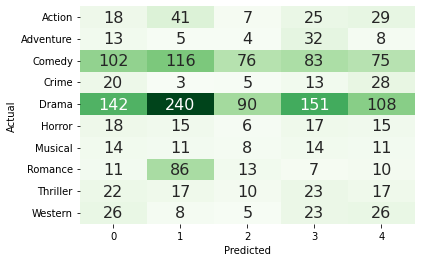

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

labels_predicted = [str(value) for value in list(assignments.values())]

cm = confusion_matrix(train_data[:,2], labels_predicted)

colour_map = sn.color_palette("Greens", as_cmap=True)
labels = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western']
plot = sn.heatmap(cm[5:,:5], 
                  annot=True, # Put the numbers in
                  annot_kws={"size": 16}, # Make the numbers bigger
                  fmt='g', # Stop scientific notation
                  cmap = colour_map, # Choose the colour palette
                  cbar = False, # Don't include the colour bar
                  xticklabels=['0','1','2','3','4'], # Put in the X and Y labels
                  yticklabels=labels)
plot.set(xlabel='Predicted', ylabel='Actual')



#  Q3 Comparing Classifiers


Confusion matrix function for comparing classifiers

In [ ]:
def plotConfusionMatrix(labels_val, labels_predicted):
  cm = confusion_matrix(labels_val, labels_predicted)
  colour_map = sn.color_palette("Greens", as_cmap=True)
  labels = labels = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama', 'Horror', 'Musical', 'Romance', 'Thriller', 'Western']
  plot = sn.heatmap(cm, 
                    annot=True, # Put the numbers in
                    annot_kws={"size": 16}, # Make the numbers bigger
                    fmt='g', # Stop scientific notation
                    cmap = colour_map, # Choose the colour palette
                    cbar = False, # Don't include the colour bar
                    xticklabels=labels, # Put in the X and Y labels
                    yticklabels=labels)
  plot.set(xlabel='Predicted', ylabel='Actual')
  return plot
     

Most Frequent classifier

accuracy=0.362
precision=0.036


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall=0.100
f1=0.053


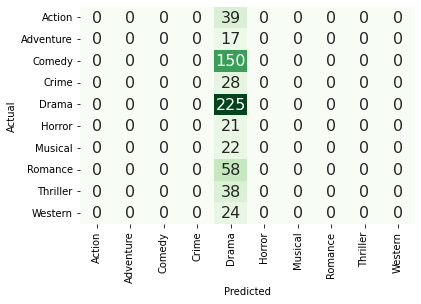

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

vectorizer = TfidfVectorizer()
training_X = vectorizer.fit_transform(train_data[:,1])
validate_X = vectorizer.fit_transform(validation_data[:,1])

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(training_X, train_data[:,2])
labels_predicted = dummy_clf.predict(validate_X)


plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")


Stratified classifier

accuracy=0.196
precision=0.080
recall=0.079
f1=0.078


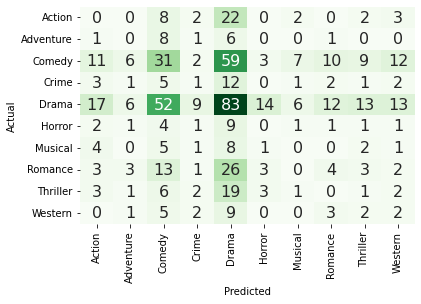

In [ ]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(training_X, train_data[:,2])
labels_predicted = dummy_clf.predict(validate_X)

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

LogisticRegression with One-hot vectorization

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy=0.439


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=0.454
recall=0.229
f1=0.261


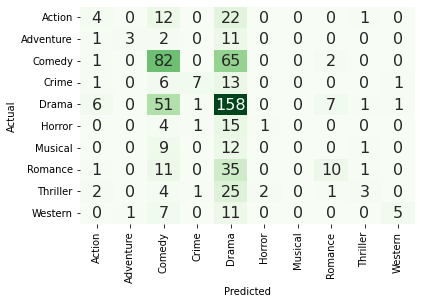

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = CountVectorizer(binary = True)
X_train = vectorizer.fit_transform(train_data[:,1])
X_val = vectorizer.transform(validation_data[:,1])


clf = LogisticRegression(random_state=42)
clf.fit(X_train,train_data[:,2])
labels_predicted = clf.predict(X_val)


plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

LogisticRegression with TF-IDF vectorization (default settings)

accuracy=0.410


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=0.087
recall=0.123
f1=0.092


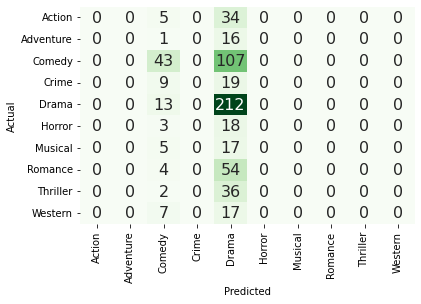

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data[:,1])
X_val = vectorizer.transform(validation_data[:,1])


clf = LogisticRegression(random_state=42)
clf.fit(X_train,train_data[:,2])
labels_predicted = clf.predict(X_val)


plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

SVC Classifier with One-hot vectorization (SVM with RBF kernel, default settings)

accuracy=0.370


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=0.087
recall=0.104
f1=0.064


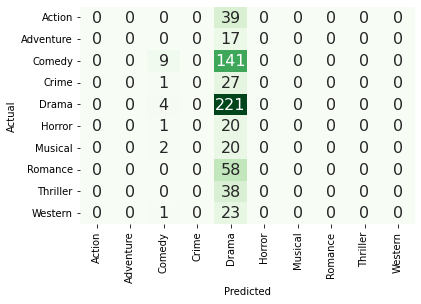

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


vectorizer = CountVectorizer(binary = True)
X_train = vectorizer.fit_transform(train_data[:,1])
X_val = vectorizer.transform(validation_data[:,1])

clf = SVC(kernel='rbf')
clf.fit(X_train,train_data[:,2])
labels_predicted = clf.predict(X_val)

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

3(b) - Choose your own classifier/tokenisation/normalisation approach from Scikit Learn

accuracy=0.492
precision=0.551
recall=0.329
f1=0.382


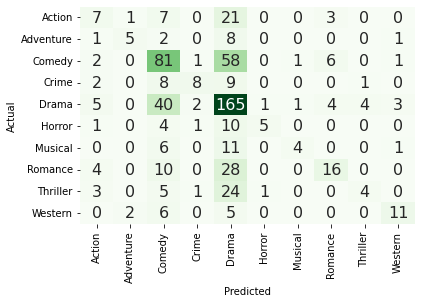

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data[:,1])
X_val = vectorizer.transform(validation_data[:,1])

clf = make_pipeline(LinearSVC(random_state=42, tol=1e-5, C=12))
clf.fit(X_train,train_data[:,2])
labels_predicted = clf.predict(X_val)

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

#Q4 Parameter Tuning


 improve the effectiveness of the LogisticRegression with TF-IDF vectorisation

accuracy=0.461
precision=0.600
recall=0.287
f1=0.341


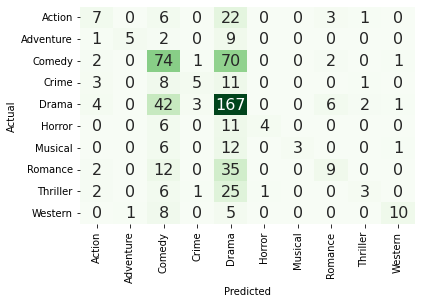

In [ ]:
vectorizer = TfidfVectorizer(max_features=8000,ngram_range=(1,1),sublinear_tf=True)
X_train = vectorizer.fit_transform(train_data[:,1])
X_val = vectorizer.transform(validation_data[:,1])


clf = LogisticRegression(random_state=42,C=2000,max_iter = 1000,)
clf.fit(X_train,train_data[:,2])
labels_predicted = clf.predict(X_val)


plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

# Q5 - Context vectors using BERT

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
from transformers import pipeline

model = pipeline('feature-extraction', model="roberta-base")
     

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch

In [ ]:
import torch

first_vector_training = torch.stack([model(text,return_tensors='pt', max_length=512, truncation=True)[0,0,:] for text in train_data[:,1]]).detach().numpy()
first_vector_validation = torch.stack([model(text,return_tensors='pt', max_length=512, truncation=True)[0,0,:] for text in validation_data[:,1]]).detach().numpy()


# train Logistic Regression classifier on training data
clf = LogisticRegression(random_state=42)
clf.fit(first_vector_training, train_data[:,2])

# make predictions on validation data
labels_predicted = clf.predict(first_vector_validation)

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

5(b) 

In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset

genre_to_id = {'drama': 0, 'comedy': 1, 'romance': 2, 'action': 3, 'western': 4, 'thriller': 5, 'crime': 6, 'horror': 7, 'adventure': 8, 'musical': 9}
id_to_genre = {0: 'drama', 1: 'comedy', 2: 'romance', 3: 'action', 4: 'western', 5: 'thriller', 6: 'crime', 7: 'horror', 8: 'adventure', 9: 'musical'}


train_data_dict = {'label':[genre_to_id[label] for label in train_data[:,2]], 'text':train_data[:,1]}
validation_data_dict = {'label':[genre_to_id[label] for label in validation_data[:,2]], 'text':validation_data[:,1]}
test_data_dict = {'label':[genre_to_id[label] for label in test_data[:,2]], 'text':test_data[:,1]}

train_dataset = Dataset.from_dict(train_data_dict)
validation_dataset = Dataset.from_dict(validation_data_dict)
test_dataset = Dataset.from_dict(test_data_dict)

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=10, id2label=id_to_genre, label2id=genre_to_id)



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], max_length=100, padding=True, truncation=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)

tokenized_train_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])
tokenized_validation_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Map:   0%|          | 0/637 [00:00<?, ? examples/s]

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator, 
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.928823


TrainOutput(global_step=239, training_loss=1.9030944313464304, metrics={'train_runtime': 2530.1952, 'train_samples_per_second': 0.754, 'train_steps_per_second': 0.094, 'total_flos': 98108414602800.0, 'train_loss': 1.9030944313464304, 'epoch': 1.0})

In [ ]:
predictions = trainer.predict(tokenized_validation_dataset).predictions
labels_predicted = [id_to_genre[np.argmax(prediction)] for prediction in predictions]

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

 5(c) - Try different values for the model, learning_rate, epochs and batch_size. 

changed model to bert-large-cased

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-cased")
model = AutoModelForSequenceClassification.from_pretrained('bert-large-cased', num_labels=10, id2label=id_to_genre, label2id=genre_to_id)

def preprocess_function(examples):
    return tokenizer(examples["text"], max_length=300, padding=True, truncation=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)

tokenized_train_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])
tokenized_validation_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator, 
)

trainer.train()

predictions = trainer.predict(tokenized_validation_dataset).predictions
labels_predicted = [id_to_genre[np.argmax(prediction)] for prediction in predictions]

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")

bert-large-cased-whole-word-masking

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("bert-large-cased-whole-word-masking")
model = AutoModelForSequenceClassification.from_pretrained('bert-large-cased-whole-word-masking', num_labels=10, id2label=id_to_genre, label2id=genre_to_id)

def preprocess_function(examples):
    return tokenizer(examples["text"], max_length=300, padding=True, truncation=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)

tokenized_train_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])
tokenized_validation_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])

ata_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator, 
)

trainer.train()

predictions = trainer.predict(tokenized_validation_dataset).predictions
labels_predicted = [id_to_genre[np.argmax(prediction)] for prediction in predictions]

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")




roberta-base-openai-detector

In [ ]:

tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
model = AutoModelForSequenceClassification.from_pretrained('roberta-base-openai-detector', num_labels=10, id2label=id_to_genre, label2id=genre_to_id)

def preprocess_function(examples):
    return tokenizer(examples["text"], max_length=300, padding=True, truncation=True)

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_validation_dataset = validation_dataset.map(preprocess_function, batched=True)

tokenized_train_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])
tokenized_validation_dataset.set_format(type='torch', columns=['input_ids','label','attention_mask'])

ata_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="language_prediction",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0,
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator, 
)

trainer.train()

predictions = trainer.predict(tokenized_validation_dataset).predictions
labels_predicted = [id_to_genre[np.argmax(prediction)] for prediction in predictions]

plotConfusionMatrix(validation_data[:,2], labels_predicted)

accuracy = accuracy_score(validation_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(validation_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")




#Q6 - Conclusions and Future Work 

6(a) - Evaluate with the test set

In [ ]:


predictions = trainer.predict(tokenized_validation_dataset).predictions
labels_predicted = [id_to_genre[np.argmax(prediction)] for prediction in predictions]

plotConfusionMatrix(test_data[:,2], labels_predicted)

accuracy = accuracy_score(test_data[:,2], labels_predicted)
print(f"{accuracy=:.3f}")

precision = precision_score(test_data[:,2], labels_predicted, average="macro")
print(f"{precision=:.3f}")

recall = recall_score(test_data[:,2], labels_predicted, average="macro")
print(f"{recall=:.3f}")

f1 = f1_score(test_data[:,2], labels_predicted, average="macro")
print(f"{f1=:.3f}")


6(b) - Manually examine the predictions on the test set

In [ ]:
for i in range(len(test_data[:,1])):
  if (test_data[i,2] != labels_predicted[i]):
    print(test_data[i,1], test_data[i,2], labels_predicted[i])
    print()